In [ ]:
from google.colab import files
from tqdm import tqdm
import gcsfs
import os
import pandas as pd
import glob
import dask.dataframe as dd
import gc
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from dask.diagnostics import ProgressBar
import numpy as np
import calendar
import networkx as nx
import itertools
import random
import pickle
from datetime import datetime

In [ ]:
# adding a progress bar for every code run using dask
ProgressBar().register()

In [ ]:
uploaded = files.upload()

Saving zippy-avatar-454716-s7-6ce326d91b28.json to zippy-avatar-454716-s7-6ce326d91b28.json


In [ ]:
fs = gcsfs.GCSFileSystem(project='zippy-avatar-454716-s7',
                         token='/content/zippy-avatar-454716-s7-6ce326d91b28.json')

In [ ]:
# making a dir for storing the data
local_dir_common = "/content/common_devs_2019_2020_export"
os.makedirs(local_dir_common, exist_ok = True)

In [ ]:
files_common = fs.glob("github-networks-bucket/common_devs_2019_2020_export/*.parquet")

In [ ]:
# downloading the data
for file in tqdm(files_common, desc="Downloading common devs data", unit="file"):
    local_path = os.path.join(local_dir_common, os.path.basename(file))
    with fs.open(file, 'rb') as fsrc, open(local_path, 'wb') as fdst:
        fdst.write(fsrc.read())

In [ ]:
df_common_devs = dd.read_parquet("/content/common_devs_2019_2020_export/*.parquet")

In [ ]:
df_common_devs['created_at'] = dd.to_datetime(df_common_devs['created_at'])

In [ ]:
common_devs = set(df_common_devs['actor'].compute())

[########################################] | 100% Completed | 11.17 s


In [ ]:
# finding the unique number of developers who are active in both 2019 and 2020
len(common_devs)

1487106

In [ ]:
# making separate df's for analysis based on years
df_common_2019 = df_common_devs[df_common_devs['created_at'].dt.year == 2019]
df_common_2020 = df_common_devs[df_common_devs['created_at'].dt.year == 2020]

In [ ]:
# checking the count of event types
df_common_2019['type'].value_counts().compute()

[########################################] | 100% Completed | 119.01 s


,count
type,
MemberEvent,90867
ReleaseEvent,220498
CommitCommentEvent,137677
ForkEvent,2227625
GollumEvent,207535
PullRequestReviewCommentEvent,2392506
IssueCommentEvent,7260006
PullRequestEvent,5227958
PushEvent,16595198


In [ ]:
# to verify the common devs in both 2019 and 2020
# Using dask to create a lazy df from the previous data files
df_feb_apr_19 = dd.read_parquet("/content/feb_apr_2019_export/*.parquet")
df_feb_apr_20 = dd.read_parquet("/content/feb_apr_2020_export/*.parquet")

In [ ]:
# getting the common devs count from each year
devs_2019 = set(df_feb_apr_19['actor'].compute())
devs_2020 = set(df_feb_apr_20['actor'].compute())

[########################################] | 100% Completed | 5.46 s
[########################################] | 100% Completed | 10.48 s


In [ ]:
# counting the common devs in both years
common_devs = devs_2019.intersection(devs_2020)
len(common_devs)

1487106

This verifies that the query was correct, and we can proceed with analysis on developer who were active in 2019 and 2020.

**Event Type Analysis**

In [ ]:
# making a copy of df for collaboration trend analysis
com_collab_19 = df_common_2019.copy()
com_collab_20 = df_common_2020.copy()

In [ ]:
# dropping unneccessary columns
com_collab_19 = com_collab_19.drop('payload', axis = 1)
com_collab_20 = com_collab_20.drop('payload', axis = 1)

In [ ]:
# changing the created_at column format to date time
com_collab_19['created_at'] = dd.to_datetime(com_collab_19['created_at'])
com_collab_20['created_at'] = dd.to_datetime(com_collab_20['created_at'])

In [ ]:
# making a new week column with the date of the start of the event week
com_collab_20['week'] = com_collab_20['created_at'].dt.to_period('W').dt.start_time
com_collab_19['week'] = com_collab_19['created_at'].dt.to_period('W').dt.start_time

In [ ]:
# grouping by week and type of events to count events
com_event_19 = com_collab_19.groupby(['week', 'type']).size().compute().reset_index(name='counts')
com_event_20 = com_collab_20.groupby(['week', 'type']).size().compute().reset_index(name='counts')

[########################################] | 100% Completed | 183.66 s
[########################################] | 100% Completed | 186.14 s


In [ ]:
# function to generate week labels from datetime
def week_label(date):
  month = calendar.month_abbr[date.month]
  week_number = ((date.day - 1) // 7) + 1
  suffix = {1: '1st', 2: '2nd', 3: '3rd'}.get(week_number, f'{week_number}th')
  return f'{month}_{suffix}_week'

In [ ]:
# adding week labels for each df
com_event_19['week_label'] = com_event_19['week'].apply(week_label)
com_event_20['week_label'] = com_event_20['week'].apply(week_label)

Dropping January 4th weeks data in both years and April 5th week in 2020, as it is a partial week with very little data, which is skewing the analysis and giving abnormal results.

In [ ]:
# dropping Jan 4th weeks in both years and Apr 5th week in 2019
com_event_19 = com_event_19[~com_event_19['week_label'].isin(['Jan_4th_week', 'Apr_5th_week'])]
com_event_20 = com_event_20[com_event_20['week_label'] != 'Jan_4th_week']

In [ ]:
!# normalizing the counts for partial weeks
# creating a new column with event date
com_collab_19['event_date'] = com_collab_19['created_at'].dt.date
com_collab_20['event_date'] = com_collab_20['created_at'].dt.date

# grouping to count unique days in each week
days_per_week_20 = com_collab_20.groupby('week')['event_date'].nunique().compute()

# mapping actual days into metrics
com_event_20['week_days'] = com_event_20['week'].map(days_per_week_20)

# adding a new column normalized counts
com_event_20['counts'] = (com_event_20['counts'] / com_event_20['week_days']) * 7

[########################################] | 100% Completed | 123.72 s


In [ ]:
# adding year labels
com_event_19 = com_event_19.copy()
com_event_20 = com_event_20.copy()

com_event_19['year'] = '2019'
com_event_20['year'] = '2020'

In [ ]:
# pivoting the table
com_pivot_19 = com_event_19.pivot_table(
    index = ['week', 'week_label'],
    columns = 'type',
    values = 'counts'
).sort_values('week').reset_index()

com_pivot_20 = com_event_20.pivot_table(
    index = ['week', 'week_label'],
    columns = 'type',
    values = 'counts'
).sort_values('week').reset_index()

In [ ]:
com_pivot_19

type,week,week_label,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PushEvent,ReleaseEvent,WatchEvent
0,2019-02-04,Feb_1st_week,9844.0,248797.0,127534.0,113703.0,14238.0,511338.0,184282.0,7165.0,5.0,364661.0,168779.0,1169900.0,15418.0,468354.0
1,2019-02-11,Feb_2nd_week,10742.0,291441.0,181411.0,157296.0,16368.0,599392.0,210619.0,7290.0,4.0,413047.0,194954.0,1265189.0,16985.0,668727.0
2,2019-02-18,Feb_3rd_week,11006.0,288956.0,143337.0,174380.0,15881.0,589455.0,214726.0,7926.0,5.0,418882.0,189474.0,1271996.0,17465.0,703335.0
3,2019-02-25,Feb_4th_week,10595.0,301026.0,154130.0,180238.0,18234.0,607210.0,221557.0,7865.0,5.0,426463.0,198760.0,1351358.0,18646.0,720141.0
4,2019-03-04,Mar_1st_week,10915.0,277264.0,148011.0,179463.0,19684.0,600080.0,213219.0,6740.0,7.0,419967.0,195695.0,1323573.0,17680.0,729921.0
5,2019-03-11,Mar_2nd_week,11127.0,283322.0,139034.0,176020.0,19559.0,581740.0,212263.0,7369.0,5.0,415686.0,191996.0,1306607.0,17914.0,703297.0
6,2019-03-18,Mar_3rd_week,10799.0,279722.0,154630.0,182967.0,16459.0,579693.0,207957.0,7631.0,9.0,428810.0,191463.0,1370478.0,17448.0,716150.0
7,2019-03-25,Mar_4th_week,10563.0,322401.0,182877.0,183059.0,16599.0,620568.0,219958.0,7428.0,5.0,427065.0,198950.0,1344212.0,18482.0,823229.0
8,2019-04-01,Apr_1st_week,10750.0,299193.0,158585.0,178831.0,16519.0,580561.0,209972.0,7400.0,3.0,440850.0,197121.0,1382032.0,18360.0,727418.0
9,2019-04-08,Apr_2nd_week,11028.0,293359.0,150384.0,187852.0,15765.0,579275.0,206136.0,7300.0,7.0,421238.0,194999.0,1344743.0,17309.0,769932.0


In [ ]:
com_pivot_20

type,week,week_label,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PullRequestEvent,PullRequestReviewCommentEvent,PushEvent,ReleaseEvent,WatchEvent
0,2020-02-03,Feb_1st_week,21446.0,334785.00,165729.0,129011.0,13214.00,600616.00,207513.0,7012.0,574174.00,219010.0,1418282.0,24791.0,537500.0
1,2020-02-10,Feb_2nd_week,21084.0,419336.00,211623.0,136664.0,12834.00,649222.00,209261.0,6916.0,692147.00,223773.0,1447893.0,26149.0,567987.0
2,2020-02-17,Feb_3rd_week,19486.0,342213.00,176890.0,138290.0,12927.00,609802.00,207623.0,6827.0,571421.00,216576.0,1425679.0,24559.0,595770.0
3,2020-02-24,Feb_4th_week,19884.0,704478.00,319790.0,142937.0,12853.00,757427.00,222351.0,6516.0,1063853.00,221673.0,1451165.0,25592.0,599489.0
4,2020-03-02,Mar_1st_week,19483.0,513076.00,326231.0,146415.0,13906.00,766193.00,209952.0,6377.0,890240.00,230151.0,1493606.0,25398.0,613965.0
5,2020-03-09,Mar_2nd_week,21000.0,907106.00,213144.0,146254.0,12245.00,658494.00,223712.0,6596.0,1152476.00,232877.0,1510762.0,24222.0,599772.0
6,2020-03-16,Mar_3rd_week,24477.0,527647.00,215051.0,144099.0,12770.00,656722.00,211583.0,7640.0,777146.00,247958.0,1557561.0,27381.0,592535.0
7,2020-03-23,Mar_4th_week,27936.0,414876.00,242113.0,152670.0,15158.00,731369.00,235040.0,8249.0,720543.00,263769.0,1625945.0,33837.0,628118.0
8,2020-03-30,Mar_5th_week,31971.0,1045677.00,255794.0,154944.0,14809.00,783648.00,244174.0,8109.0,1336453.00,263819.0,1685884.0,30655.0,640198.0
9,2020-04-06,Apr_1st_week,31905.0,440321.00,217595.0,156768.0,13917.00,717533.00,243635.0,7091.0,715078.00,254166.0,1711250.0,29669.0,652959.0


In [ ]:
# droping week column and setting index to week_label
com_pivot_19 = com_pivot_19.drop(columns = 'week').set_index('week_label')
com_pivot_20 = com_pivot_20.drop(columns = 'week').set_index('week_label')

In [ ]:
pct_change_19 = com_pivot_19.pct_change().multiply(100).round(2).add_suffix('_2019')
pct_change_20 = com_pivot_20.pct_change().multiply(100).round(2).add_suffix('_2020')

In [ ]:
# droping the 1st row
pct_change_19 = pct_change_19.iloc[1:]
pct_change_20 = pct_change_20.iloc[1:]

In [ ]:
pct_change_19

type,CommitCommentEvent_2019,CreateEvent_2019,DeleteEvent_2019,ForkEvent_2019,GollumEvent_2019,IssueCommentEvent_2019,IssuesEvent_2019,MemberEvent_2019,PublicEvent_2019,PullRequestEvent_2019,PullRequestReviewCommentEvent_2019,PushEvent_2019,ReleaseEvent_2019,WatchEvent_2019
week_label,,,,,,,,,,,,,,
Feb_2nd_week,9.12,17.14,42.25,38.34,14.96,17.22,14.29,1.74,-20.00,13.27,15.51,8.15,10.16,42.78
Feb_3rd_week,2.46,-0.85,-20.99,10.86,-2.98,-1.66,1.95,8.72,25.00,1.41,-2.81,0.54,2.83,5.18
Feb_4th_week,-3.73,4.18,7.53,3.36,14.82,3.01,3.18,-0.77,0.00,1.81,4.90,6.24,6.76,2.39
Mar_1st_week,3.02,-7.89,-3.97,-0.43,7.95,-1.17,-3.76,-14.30,40.00,-1.52,-1.54,-2.06,-5.18,1.36
Mar_2nd_week,1.94,2.18,-6.07,-1.92,-0.64,-3.06,-0.45,9.33,-28.57,-1.02,-1.89,-1.28,1.32,-3.65
Mar_3rd_week,-2.95,-1.27,11.22,3.95,-15.85,-0.35,-2.03,3.56,80.00,3.16,-0.28,4.89,-2.60,1.83
Mar_4th_week,-2.19,15.26,18.27,0.05,0.85,7.05,5.77,-2.66,-44.44,-0.41,3.91,-1.92,5.93,14.95
Apr_1st_week,1.77,-7.20,-13.28,-2.31,-0.48,-6.45,-4.54,-0.38,-40.00,3.23,-0.92,2.81,-0.66,-11.64
Apr_2nd_week,2.59,-1.95,-5.17,5.04,-4.56,-0.22,-1.83,-1.35,133.33,-4.45,-1.08,-2.70,-5.72,5.84


In [ ]:
pct_change_20

type,CommitCommentEvent_2020,CreateEvent_2020,DeleteEvent_2020,ForkEvent_2020,GollumEvent_2020,IssueCommentEvent_2020,IssuesEvent_2020,MemberEvent_2020,PullRequestEvent_2020,PullRequestReviewCommentEvent_2020,PushEvent_2020,ReleaseEvent_2020,WatchEvent_2020
week_label,,,,,,,,,,,,,
Feb_2nd_week,-1.69,25.26,27.69,5.93,-2.88,8.09,0.84,-1.37,20.55,2.17,2.09,5.48,5.67
Feb_3rd_week,-7.58,-18.39,-16.41,1.19,0.72,-6.07,-0.78,-1.29,-17.44,-3.22,-1.53,-6.08,4.89
Feb_4th_week,2.04,105.86,80.78,3.36,-0.57,24.21,7.09,-4.56,86.18,2.35,1.79,4.21,0.62
Mar_1st_week,-2.02,-27.17,2.01,2.43,8.19,1.16,-5.58,-2.13,-16.32,3.82,2.92,-0.76,2.41
Mar_2nd_week,7.79,76.80,-34.66,-0.11,-11.94,-14.06,6.55,3.43,29.46,1.18,1.15,-4.63,-2.31
Mar_3rd_week,16.56,-41.83,0.89,-1.47,4.29,-0.27,-5.42,15.83,-32.57,6.48,3.10,13.04,-1.21
Mar_4th_week,14.13,-21.37,12.58,5.95,18.70,11.37,11.09,7.97,-7.28,6.38,4.39,23.58,6.01
Mar_5th_week,14.44,152.05,5.65,1.49,-2.30,7.15,3.89,-1.70,85.48,0.02,3.69,-9.40,1.92
Apr_1st_week,-0.21,-57.89,-14.93,1.18,-6.02,-8.44,-0.22,-12.55,-46.49,-3.66,1.50,-3.22,1.99


In [ ]:
# joining both year's event type counts percent changes to 1 df
weekly_com_event_change = pct_change_19.join(pct_change_20, how = 'inner')

In [ ]:
weekly_com_event_change.head()

type,CommitCommentEvent_2019,CreateEvent_2019,DeleteEvent_2019,ForkEvent_2019,GollumEvent_2019,IssueCommentEvent_2019,IssuesEvent_2019,MemberEvent_2019,PublicEvent_2019,PullRequestEvent_2019,...,ForkEvent_2020,GollumEvent_2020,IssueCommentEvent_2020,IssuesEvent_2020,MemberEvent_2020,PullRequestEvent_2020,PullRequestReviewCommentEvent_2020,PushEvent_2020,ReleaseEvent_2020,WatchEvent_2020
week_label,,,,,,,,,,,,,,,,,,,,,
Feb_2nd_week,9.12,17.14,42.25,38.34,14.96,17.22,14.29,1.74,-20.00,13.27,...,5.93,-2.88,8.09,0.84,-1.37,20.55,2.17,2.09,5.48,5.67
Feb_3rd_week,2.46,-0.85,-20.99,10.86,-2.98,-1.66,1.95,8.72,25.00,1.41,...,1.19,0.72,-6.07,-0.78,-1.29,-17.44,-3.22,-1.53,-6.08,4.89
Feb_4th_week,-3.73,4.18,7.53,3.36,14.82,3.01,3.18,-0.77,0.00,1.81,...,3.36,-0.57,24.21,7.09,-4.56,86.18,2.35,1.79,4.21,0.62
Mar_1st_week,3.02,-7.89,-3.97,-0.43,7.95,-1.17,-3.76,-14.30,40.00,-1.52,...,2.43,8.19,1.16,-5.58,-2.13,-16.32,3.82,2.92,-0.76,2.41
Mar_2nd_week,1.94,2.18,-6.07,-1.92,-0.64,-3.06,-0.45,9.33,-28.57,-1.02,...,-0.11,-11.94,-14.06,6.55,3.43,29.46,1.18,1.15,-4.63,-2.31


In [ ]:
weekly_com_event_change.to_csv('weekly_com_event_change.csv', index = False)

In [ ]:
def plot_event_changes(event_name, df):
  col_2019 = f'{event_name}_2019'
  col_2020 = f'{event_name}_2020'

  data = df[[col_2019, col_2020]].dropna()

  plt.figure(figsize=(12, 6))
  plt.plot(data.index, data[col_2019], marker = 'o', label = '2019', linewidth = 2)
  plt.plot(data.index, data[col_2020], marker = 's', label = '2020', linewidth = 2)

  plt.title(f'weekly % change in {event_name} events 2019 vs 2020', fontsize = 14)
  plt.xlabel('week', fontsize = 12)
  plt.ylabel('% change', fontsize = 12)
  plt.xticks(rotation = 45)
  plt.grid(True, linestyle = '--', alpha = 0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()

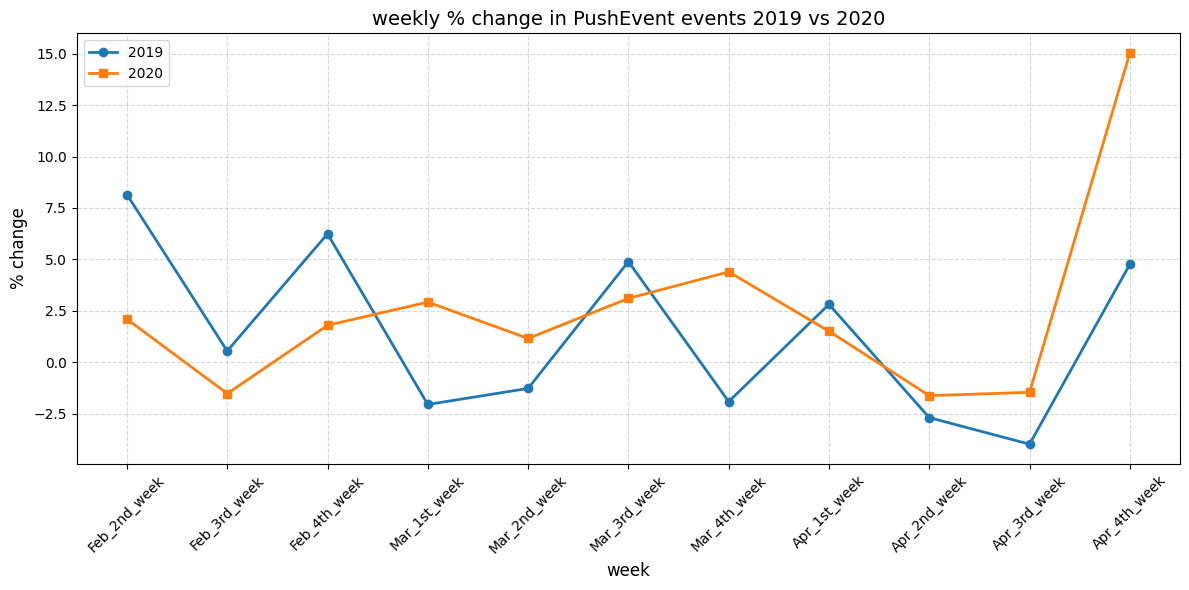

In [ ]:
plot_event_changes('PushEvent', weekly_com_event_change)

The weekly percentage change in PushEvent activity among common developers shows steadier behavior in 2020 compared to 2019, with most changes ranging between -2% to +4%. However, in April 4th week 2020, there is a sharp spike of 14%, compared to 4.8% in 2019, which shows a possible post adjustment increase in commits as developers settled into remote workflows. In contrast, 2019 shows more frequent fluctuations, including some dips near 3% in early March and Apri. This pattern suggests that while developer activity remained stable for common contributors during COVID, collaboration intensity surged briefly later.

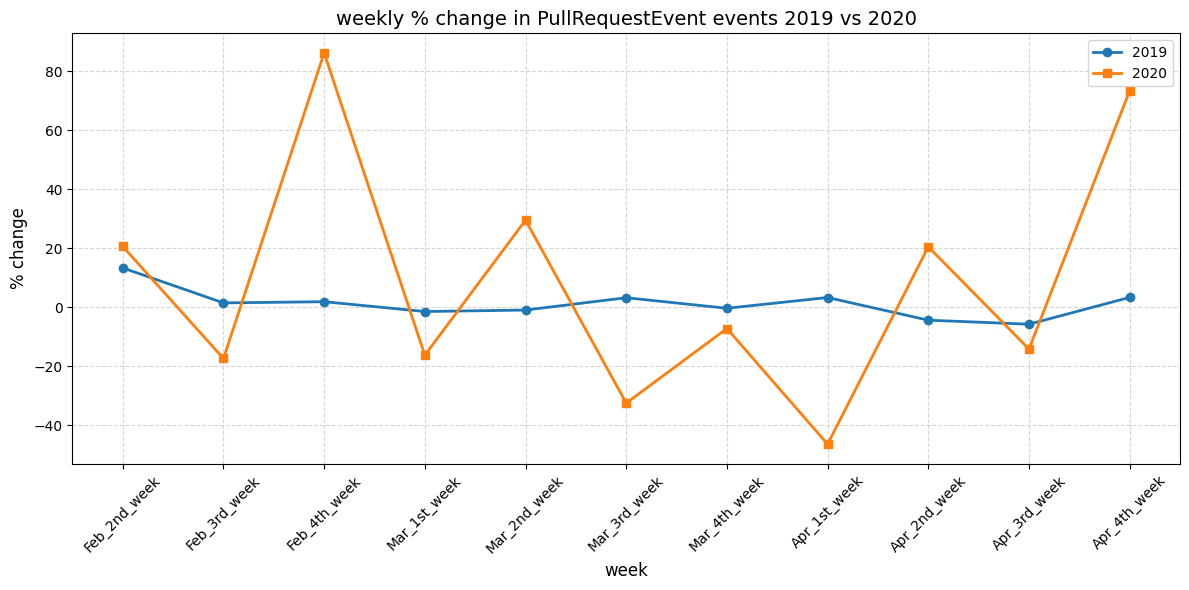

In [ ]:
plot_event_changes('PullRequestEvent', weekly_com_event_change)

In 2020, Pull request event activity among common developers was much more volatile, jumping by 85.6% in Febuary 4th week and again by 76.6% in April 4th week, but also crashing by -46.8% in April 1st week. In contrast, 2019 showed minimal weekly changes, mostly between -3% to +5%, indicating steadier collaboration. These fluctuations in 2020 suggest a disrupted and reactive pattern in code contributions during the early COVID phase.

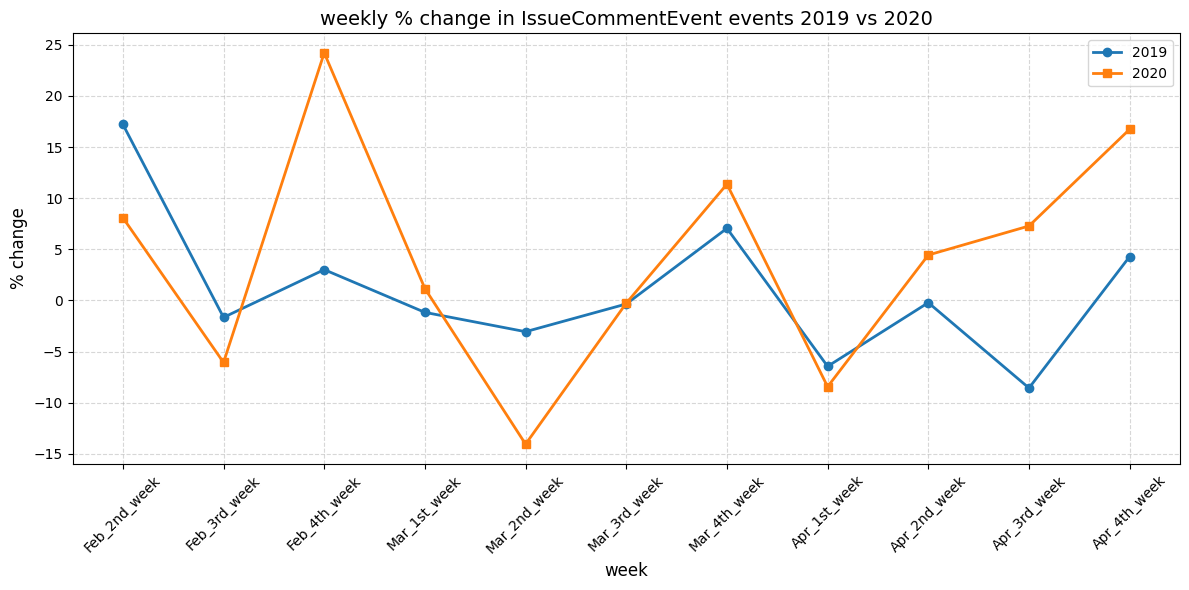

In [ ]:
plot_event_changes('IssueCommentEvent', weekly_com_event_change)

In 2020, comment activity was more erratic, spiking by 24.1% in Febuary 4th week and 17% in April 4th week, but dropping by 13.8% in March 2nd week. Meanwhile, 2019 had steadier changes, mostly within the range of -7% to +7%, showing more stable collaboration. The volatility in 2020 suggests varying team communication as developers adjusted to early COVID-19 disruptions.

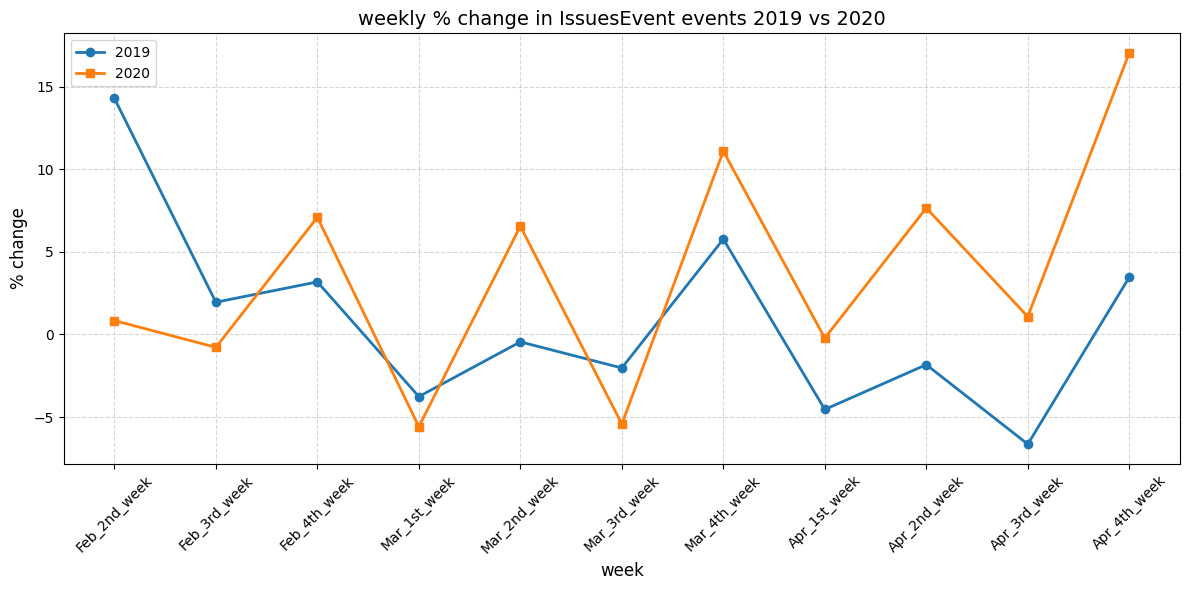

In [ ]:
plot_event_changes('IssuesEvent', weekly_com_event_change)

In 2020, issue related activity was more dynamic, with notable spikes like 11.2% in March 4th week and 17.2% in April 4th week. In contrast, 2019 changes were more muted, mostly under -6% to +6% except a peak of 14.3% in Febuary 2nd week. These jumps in 2020 may reflect changes in issue tracking or project management as developers adapted to early COVID-19 conditions.

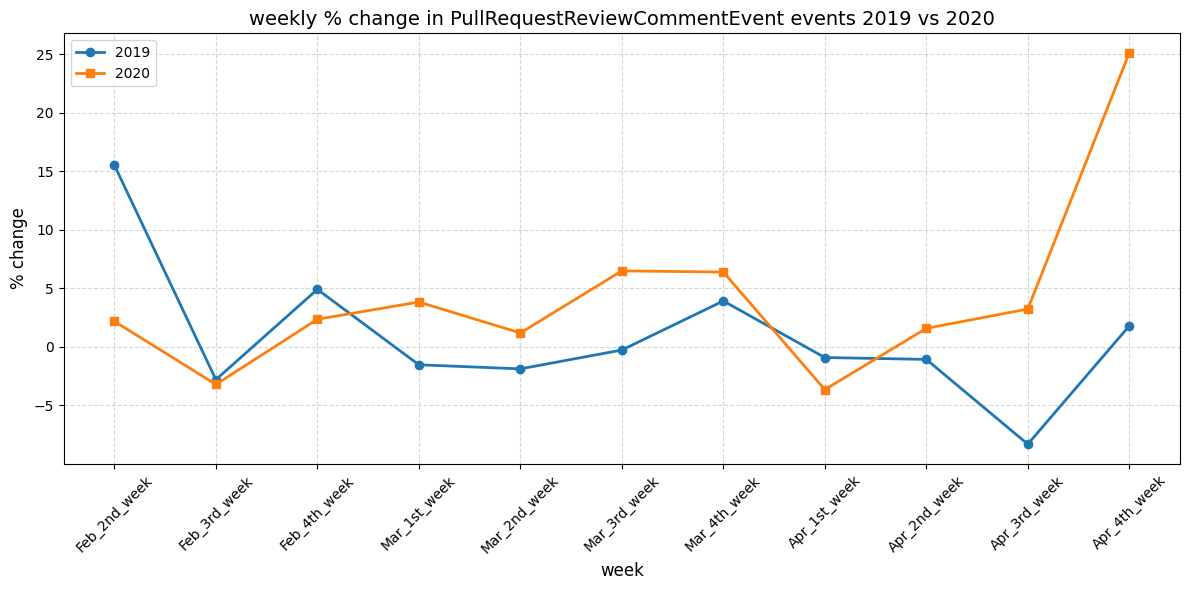

In [ ]:
plot_event_changes('PullRequestReviewCommentEvent', weekly_com_event_change)

In 2020, PullRequestReviewCommentEvent activity showed steady growth through March, peaking at 25% in April 4th week much higher than any week in 2019. In comparison, 2019 remained relatively flat, mostly within +5% to -5%. The post March surge in 2020 suggests increased focus on code review and collaboration after the onset of COVID-19.

Network analysis

In [ ]:
# selecting relevant columns for network analysis
com_network_19 = df_common_2019[['created_at', 'repo', 'actor']]
com_network_20 = df_common_2020[['created_at', 'repo', 'actor']]

In [ ]:
# changing the 'created_at' column to date time format
com_network_19['created_at'] = dd.to_datetime(com_network_19['created_at'])
com_network_20['created_at'] = dd.to_datetime(com_network_20['created_at'])

# adding a week column with the start date of the week
com_network_19['week'] = com_network_19['created_at'].dt.to_period('W').dt.start_time
com_network_20['week'] = com_network_20['created_at'].dt.to_period('W').dt.start_time

In [ ]:
def weekly_graph_build(df, save_dir):
  # making a dir if does not exist
  os.makedirs(save_dir, exist_ok=True)

  # getting a set of already completed graph files
  existing_files = set(os.listdir(save_dir))

  # a sorted list of all unique weeks
  unique_weeks = df['week'].drop_duplicates().compute().sort_values().tolist()

  # looping through each week to build graphs
  for week in tqdm(unique_weeks, desc = "Building weekly graphs"):
    # filename to save and the path to save
    filename = f"week_{week.date()}.gpickle"
    full_path = os.path.join(save_dir, filename)

    # skipping if the graph file is already present
    if filename in existing_files:
      print(f"already built the graph for {week} week")
      continue

    print(f"processing week: {week}")

    # computing the data of the week
    df_week = df[df['week'] == week].compute().copy()
    # grouping by repo and getting a list of devs on each repo
    week_repo_groups = df_week.groupby('repo')['actor'].apply(list).reset_index()

    G = nx.Graph()
    repos_skipped = 0

    # adding edges between devs who worked on the same repo
    for devs in week_repo_groups['actor']:
      # adding a cap to build the graph (to be in limit of computing power)
      if len(devs) > 1 and len(devs) < 10000:
        G.add_edges_from(itertools.combinations(set(devs), 2))
      elif len(devs) > 10000:
        repos_skipped += 1

    # saving the graph
    with open(full_path, 'wb') as file:
      pickle.dump(G, file)

    del df_week, week_repo_groups, G
    gc.collect()


In [ ]:
# building weekly graphs for 2020 data
weekly_graph_build(com_network_19, save_dir='/content/graphs/common_devs/2019')

[########################################] | 100% Completed | 112.04 s


Building weekly graphs:   0%|          | 0/14 [00:00<?, ?it/s]

processing week: 2019-01-28 00:00:00
[########################################] | 100% Completed | 218.90 s


Building weekly graphs:   7%|▋         | 1/14 [03:56<51:18, 236.82s/it]

processing week: 2019-02-04 00:00:00
[########################################] | 100% Completed | 210.72 s


Building weekly graphs:  14%|█▍        | 2/14 [08:48<53:46, 268.91s/it]

processing week: 2019-02-11 00:00:00
[########################################] | 100% Completed | 212.98 s


Building weekly graphs:  21%|██▏       | 3/14 [14:33<55:40, 303.64s/it]

processing week: 2019-02-18 00:00:00
[########################################] | 100% Completed | 210.92 s


Building weekly graphs:  29%|██▊       | 4/14 [21:18<57:17, 343.78s/it]

processing week: 2019-02-25 00:00:00
[########################################] | 100% Completed | 218.70 s


Building weekly graphs:  36%|███▌      | 5/14 [28:14<55:29, 369.95s/it]

processing week: 2019-03-04 00:00:00
[########################################] | 100% Completed | 198.34 s


Building weekly graphs:  43%|████▎     | 6/14 [34:34<49:45, 373.13s/it]

processing week: 2019-03-11 00:00:00
[########################################] | 100% Completed | 227.94 s


Building weekly graphs:  50%|█████     | 7/14 [40:24<42:39, 365.69s/it]

processing week: 2019-03-18 00:00:00
[########################################] | 100% Completed | 202.57 s


Building weekly graphs:  57%|█████▋    | 8/14 [45:44<35:06, 351.16s/it]

processing week: 2019-03-25 00:00:00
[########################################] | 100% Completed | 200.32 s


Building weekly graphs:  64%|██████▍   | 9/14 [51:16<28:46, 345.29s/it]

processing week: 2019-04-01 00:00:00
[########################################] | 100% Completed | 201.47 s


Building weekly graphs:  71%|███████▏  | 10/14 [56:41<22:35, 338.77s/it]

processing week: 2019-04-08 00:00:00
[########################################] | 100% Completed | 200.51 s


Building weekly graphs:  79%|███████▊  | 11/14 [1:02:47<17:21, 347.32s/it]

processing week: 2019-04-15 00:00:00
[########################################] | 100% Completed | 204.54 s


Building weekly graphs:  86%|████████▌ | 12/14 [1:08:19<11:24, 342.46s/it]

processing week: 2019-04-22 00:00:00
[########################################] | 100% Completed | 214.10 s


Building weekly graphs:  93%|█████████▎| 13/14 [1:17:47<06:51, 411.02s/it]

processing week: 2019-04-29 00:00:00
[########################################] | 100% Completed | 211.00 s


Building weekly graphs: 100%|██████████| 14/14 [1:21:46<00:00, 350.46s/it]


In [ ]:
# building weekly graphs for 2019 data
weekly_graph_build(com_network_20, save_dir='/content/graphs/common_devs/2020')

[########################################] | 100% Completed | 115.17 s


Building weekly graphs:   0%|          | 0/14 [00:00<?, ?it/s]

processing week: 2020-01-27 00:00:00
[########################################] | 100% Completed | 226.86 s


Building weekly graphs:   7%|▋         | 1/14 [03:56<51:19, 236.92s/it]

processing week: 2020-02-03 00:00:00
[########################################] | 100% Completed | 223.73 s


Building weekly graphs:  14%|█▍        | 2/14 [08:45<53:25, 267.10s/it]

processing week: 2020-02-10 00:00:00
[########################################] | 100% Completed | 207.98 s


Building weekly graphs:  21%|██▏       | 3/14 [13:21<49:46, 271.54s/it]

processing week: 2020-02-17 00:00:00
[########################################] | 100% Completed | 197.59 s


Building weekly graphs:  29%|██▊       | 4/14 [18:05<46:02, 276.21s/it]

processing week: 2020-02-24 00:00:00
[########################################] | 100% Completed | 202.94 s


Building weekly graphs:  36%|███▌      | 5/14 [23:03<42:36, 284.00s/it]

processing week: 2020-03-02 00:00:00
[########################################] | 100% Completed | 212.08 s


Building weekly graphs:  43%|████▎     | 6/14 [28:03<38:36, 289.54s/it]

processing week: 2020-03-09 00:00:00
[########################################] | 100% Completed | 209.79 s


Building weekly graphs:  50%|█████     | 7/14 [33:08<34:22, 294.64s/it]

processing week: 2020-03-16 00:00:00
[########################################] | 100% Completed | 222.54 s


Building weekly graphs:  57%|█████▋    | 8/14 [38:27<30:14, 302.44s/it]

processing week: 2020-03-23 00:00:00
[########################################] | 100% Completed | 226.27 s


Building weekly graphs:  64%|██████▍   | 9/14 [43:31<25:14, 302.84s/it]

processing week: 2020-03-30 00:00:00
[########################################] | 100% Completed | 239.04 s


Building weekly graphs:  71%|███████▏  | 10/14 [49:17<21:05, 316.30s/it]

processing week: 2020-04-06 00:00:00
[########################################] | 100% Completed | 225.77 s


Building weekly graphs:  79%|███████▊  | 11/14 [54:27<15:42, 314.32s/it]

processing week: 2020-04-13 00:00:00
[########################################] | 100% Completed | 193.29 s


Building weekly graphs:  86%|████████▌ | 12/14 [59:32<10:23, 311.53s/it]

processing week: 2020-04-20 00:00:00
[########################################] | 100% Completed | 205.69 s


Building weekly graphs:  93%|█████████▎| 13/14 [1:04:27<05:06, 306.46s/it]

processing week: 2020-04-27 00:00:00
[########################################] | 100% Completed | 201.69 s


Building weekly graphs: 100%|██████████| 14/14 [1:08:40<00:00, 294.33s/it]


In [ ]:
gc.collect()

16064

In [ ]:
def calc_network_metrics(graph_dir, label = None, sample_size = None):
  # initiating a list to save metrics
  metrics = []

  # getting a list of graphs sorted by week
  files = sorted(os.listdir(graph_dir))

  # looping to calculate graph metrics
  for file in tqdm(files, desc = "Calculating weekly metrics"):
    if not file.endswith('.gpickle'):
      continue

    # extracting week from the filename
    week_str = file.replace("week_", "").replace(".gpickle", "")
    week_date = datetime.strptime(week_str, '%Y-%m-%d').date()

    # loading the file
    filepath = os.path.join(graph_dir, file)

    with open(filepath, 'rb') as file:
      G = pickle.load(file)

    # skipping empty graphs
    if len(G) == 0:
      continue

    # calculating metrics
    degrees = dict(G.degree())
    avg_degree = sum(degrees.values()) / len(degrees)

    # largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()
    largest_cc_size = len(G_lcc)

    if len(G_lcc) > sample_size:
      sample_nodes = random.sample(list(G_lcc.nodes()), sample_size)
    else:
      sample_nodes = list(G_lcc.nodes())

    clustering = nx.average_clustering(G_lcc, nodes = sample_nodes)

    density = nx.density(G)
    num_components = nx.number_connected_components(G)

    metrics.append({
            'week': week_date,
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': density,
            'average_degree': avg_degree,
            'clustering_coefficient': clustering,
            'number_of_components': num_components,
            'largest_component_size': largest_cc_size,
            'label' : label
        })

    del G, G_lcc, degrees, sample_nodes, clustering, largest_cc
    gc.collect()

  df_metrics = pd.DataFrame(metrics).sort_values(by='week')

  return df_metrics

In [ ]:
# calculating 2019 graphs metrics
com_dev_metrics_2019 = calc_network_metrics(graph_dir = '/content/graphs/common_devs/2019', label = '2019', sample_size = 1000)

Calculating weekly metrics: 100%|██████████| 14/14 [2:29:25<00:00, 640.40s/it]


In [ ]:
# calculating 2020 graphs metrics
com_dev_metrics_2020 = calc_network_metrics(graph_dir = '/content/graphs/common_devs/2020', label = '2020', sample_size = 1000)

Calculating weekly metrics: 100%|██████████| 14/14 [57:59<00:00, 248.52s/it]


In [ ]:
# combining both the metrics
com_dev_combined_metrics = pd.concat([com_dev_metrics_2019, com_dev_metrics_2020], ignore_index = True)
com_dev_combined_metrics = com_dev_combined_metrics.sort_values(by = 'week').reset_index(drop = True)

In [ ]:
# saving the metrics
com_dev_combined_metrics.to_csv('common_devs_network_metrics.csv', index = False)

In [ ]:
# loading the metrics from csv to df
com_dev_combined_metrics = pd.read_csv('common_devs_network_metrics.csv', parse_dates = ['week'])
com_dev_combined_metrics['label'] = com_dev_combined_metrics['label'].astype(str)

In [ ]:
com_dev_combined_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   week                    28 non-null     datetime64[ns]
 1   num_nodes               28 non-null     int64         
 2   num_edges               28 non-null     int64         
 3   density                 28 non-null     float64       
 4   average_degree          28 non-null     float64       
 5   clustering_coefficient  28 non-null     float64       
 6   number_of_components    28 non-null     int64         
 7   largest_component_size  28 non-null     int64         
 8   label                   28 non-null     object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 2.1+ KB


In [ ]:
# making a copy of metrics
com_network_metrics = com_dev_combined_metrics.copy()

In [ ]:
# function to generate week labels from datetime
def week_label(date):
  month = calendar.month_abbr[date.month]
  week_number = ((date.day - 1) // 7) + 1
  suffix = {1: '1st', 2: '2nd', 3: '3rd'}.get(week_number, f'{week_number}th')
  return f'{month}_{suffix}_week'

In [ ]:
# adding week labels to the metrics df
com_network_metrics['week_label'] = com_network_metrics['week'].apply(week_label)

In [ ]:
# ordering the labels
weeks_ordered = com_network_metrics.sort_values('week')['week_label'].unique()
com_network_metrics['week_label'] = pd.Categorical(com_network_metrics['week_label'], categories=weeks_ordered, ordered=True)

In [ ]:
com_network_metrics

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label
0,2019-01-28,138521,5381381,0.000561,77.697692,0.807767,9935,111842,2019,Jan_4th_week
1,2019-02-04,293793,36204498,0.000839,246.462632,0.793810,11434,263893,2019,Feb_1st_week
2,2019-02-11,373199,62236361,0.000894,333.529088,0.790162,11814,342312,2019,Feb_2nd_week
3,2019-02-18,392015,92368025,0.001202,471.247401,0.787166,12187,360406,2019,Feb_3rd_week
4,2019-02-25,400425,97360184,0.001214,486.284243,0.809028,12530,367953,2019,Feb_4th_week
5,2019-03-04,401395,92032162,0.001142,458.561577,0.798937,12282,369543,2019,Mar_1st_week
6,2019-03-11,398924,59533199,0.000748,298.468876,0.794030,12868,365759,2019,Mar_2nd_week
7,2019-03-18,402231,57718920,0.000714,286.993892,0.785561,12830,368754,2019,Mar_3rd_week
8,2019-03-25,408838,68204264,0.000816,333.649338,0.780205,13050,374805,2019,Mar_4th_week
9,2019-04-01,401606,63406753,0.000786,315.765965,0.792156,13331,366944,2019,Apr_1st_week


In [ ]:
# getting extra weeks
extra_weeks = com_network_metrics[(com_network_metrics['label'] == '2020') &
                              (com_network_metrics['week_label'].isin(['Mar_4th_week', 'Mar_5th_week']))]

# getting the numeric columns for averaging
numeric_cols = ['num_nodes', 'num_edges', 'density', 'average_degree',
                'number_of_components', 'largest_component_size', 'clustering_coefficient']

avg_metrics = extra_weeks[numeric_cols].mean()

# getting previous weeks date
prev_week_date = extra_weeks['week'].min()

# create a new row for average values
merged_row = avg_metrics.to_dict()
merged_row['week'] = prev_week_date
merged_row['label'] = '2020'
merged_row['week_label'] = 'Mar_4th_week'

# removing the original two weeks and adding the new merged one
com_network_metrics = com_network_metrics[~((com_network_metrics['label'] == '2020') &
                                    (com_network_metrics['week_label'].isin(['Mar_4th_week', 'Mar_5th_week'])))]

# appending the new row
com_network_metrics = pd.concat([com_network_metrics, pd.DataFrame([merged_row])], ignore_index=True)

# sorting the weeks
com_network_metrics = com_network_metrics.sort_values('week').reset_index(drop=True)

In [ ]:
com_network_metrics.head()

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label
0,2019-01-28,138521.0,5381381.0,0.000561,77.697692,0.807767,9935.0,111842.0,2019,Jan_4th_week
1,2019-02-04,293793.0,36204498.0,0.000839,246.462632,0.793810,11434.0,263893.0,2019,Feb_1st_week
2,2019-02-11,373199.0,62236361.0,0.000894,333.529088,0.790162,11814.0,342312.0,2019,Feb_2nd_week
3,2019-02-18,392015.0,92368025.0,0.001202,471.247401,0.787166,12187.0,360406.0,2019,Feb_3rd_week
4,2019-02-25,400425.0,97360184.0,0.001214,486.284243,0.809028,12530.0,367953.0,2019,Feb_4th_week


In [ ]:
# getting number of unique days per week
com_network_19['created_date'] = com_network_19['created_at'].dt.date
com_network_20['created_date'] = com_network_20['created_at'].dt.date

days_per_week_19 = com_network_19.groupby('week')['created_date'].nunique().compute()
days_per_week_20 = com_network_20.groupby('week')['created_date'].nunique().compute()

# mapping actual days into metrics
actual_days_list = []

for _, row in com_network_metrics.iterrows():
  week_start = row['week']
  year = row['label']

  if year == '2019':
    actual_days = days_per_week_19.get(week_start, np.nan)
  elif year == '2020':
    actual_days = days_per_week_20.get(week_start, np.nan)
  else:
    actual_days = np.nan

  actual_days_list.append(actual_days)

# creating a new column with actual number of days of each week
com_network_metrics['actual_days'] = actual_days_list

[########################################] | 100% Completed | 121.46 s
[########################################] | 100% Completed | 127.07 s


In [ ]:
# normalizing the metrics for partial weeks only
numeric_cols = ['num_nodes', 'num_edges', 'density', 'average_degree',
                'number_of_components', 'largest_component_size', 'clustering_coefficient']

for col in numeric_cols:
  com_network_metrics[col] = np.where(
      com_network_metrics['actual_days'] < 7,
      (com_network_metrics[col] / com_network_metrics['actual_days']) * 7,
      com_network_metrics[col]
  )

Dropping partial weeks Jan 4th weeks in both years and April 5th week in 2019 to make sure of consistency in weekly comparision, as these weeks are skewing the analysis.

In [ ]:
# dropping partial weeks
network_metrics = com_network_metrics[~(
    ((com_network_metrics['label'] == '2019') & (com_network_metrics['week_label'].isin(['Jan_4th_week', 'Apr_5th_week']))) |
    ((com_network_metrics['label'] == '2020') & (com_network_metrics['week_label'].isin(['Jan_4th_week'])))
)]

In [ ]:
com_network_metrics.head()

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label,actual_days
0,2019-01-28,323215.666667,1.255656e+07,0.001309,181.294615,1.884791,23181.666667,260964.666667,2019,Jan_4th_week,3
1,2019-02-04,293793.000000,3.620450e+07,0.000839,246.462632,0.793810,11434.000000,263893.000000,2019,Feb_1st_week,7
2,2019-02-11,373199.000000,6.223636e+07,0.000894,333.529088,0.790162,11814.000000,342312.000000,2019,Feb_2nd_week,7
3,2019-02-18,392015.000000,9.236802e+07,0.001202,471.247401,0.787166,12187.000000,360406.000000,2019,Feb_3rd_week,7
4,2019-02-25,400425.000000,9.736018e+07,0.001214,486.284243,0.809028,12530.000000,367953.000000,2019,Feb_4th_week,7


In [ ]:
# saving the common developers final metrics
com_network_metrics.to_csv('final_com_network_metrics.csv', index = False)

In [ ]:
# loading the metrics saved in csv to a df
com_network_metrics = pd.read_csv('/content/final_network_metrics.csv', parse_dates=['week'])
com_network_metrics['label'] = com_network_metrics['label'].astype(str)

In [ ]:
# rounding the metrics to 2 decimal places
float_cols = ['num_nodes', 'num_edges', 'average_degree',
                'number_of_components', 'largest_component_size', 'clustering_coefficient']

com_network_metrics[float_cols] = com_network_metrics[float_cols].astype(float).round(2)

In [ ]:
com_network_metrics.head()

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label,actual_days
0,2019-02-04,480399.0,55696647.0,0.000483,231.88,0.08,27521.0,399571.0,2019,Feb_1st_week,7
1,2019-02-11,603490.0,96234031.0,0.000528,318.93,0.10,29187.0,517258.0,2019,Feb_2nd_week,7
2,2019-02-18,637303.0,157593146.0,0.000776,494.56,0.13,30273.0,548290.0,2019,Feb_3rd_week,7
3,2019-02-25,654151.0,177131433.0,0.000828,541.56,0.11,31398.0,561772.0,2019,Feb_4th_week,7
4,2019-03-04,657512.0,212112636.0,0.000981,645.20,0.11,31236.0,566035.0,2019,Mar_1st_week,7


In [ ]:
# creating a function to plot the metrics for both 2019 and 2020 easy way
def metrics_plot(df, metric, ylabel = None, title = None, use_log = False):
  plt.figure(figsize=(14, 6))
  # looping through each year to plot its trend
  for year in ['2019', '2020']:
    data = df[df['label'] == year]
    plt.plot(data['week_label'], data[metric], marker = 'o', label = year, linewidth = 2)

  # setting a plot title
  plt.title(title or f"{ylabel} - weekly trend (2019 vs 2020)", fontsize = 14)
  plt.xlabel('week', fontsize = 12)
  plt.ylabel(ylabel, fontsize = 12)
  plt.xticks(rotation = 45)

  ax = plt.gca()
  if use_log:
    plt.yscale('log')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
  else:
    if df[metric].max() < 1:
      ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.4f}'))
    else:
      ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

  plt.grid(True, linestyle = '--', alpha = 0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()

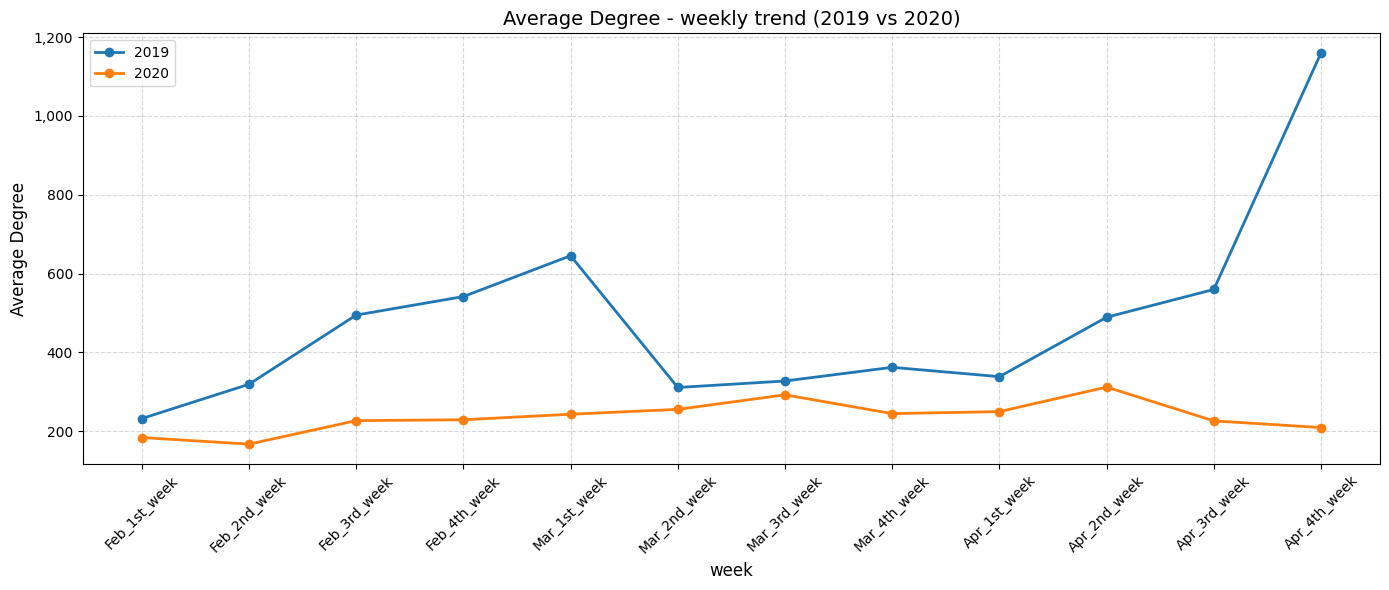

In [ ]:
metrics_plot(com_network_metrics, 'average_degree', 'Average Degree')

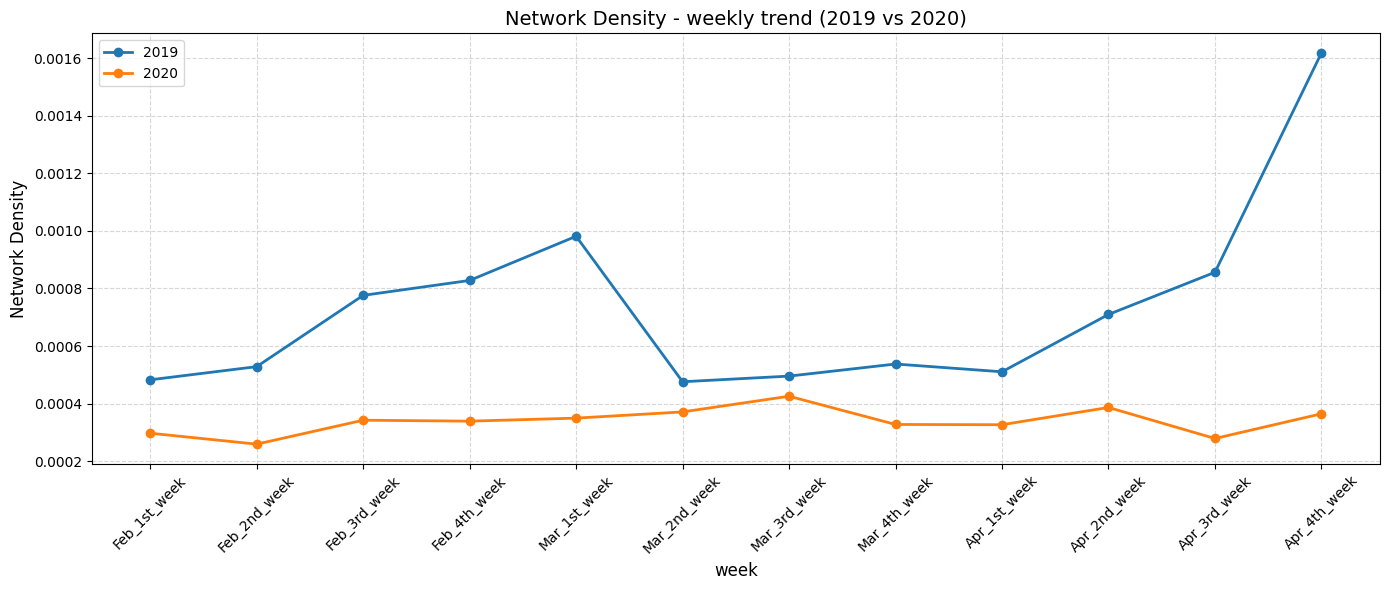

In [ ]:
# plotting for density over time
metrics_plot(com_network_metrics, 'density', 'Network Density')

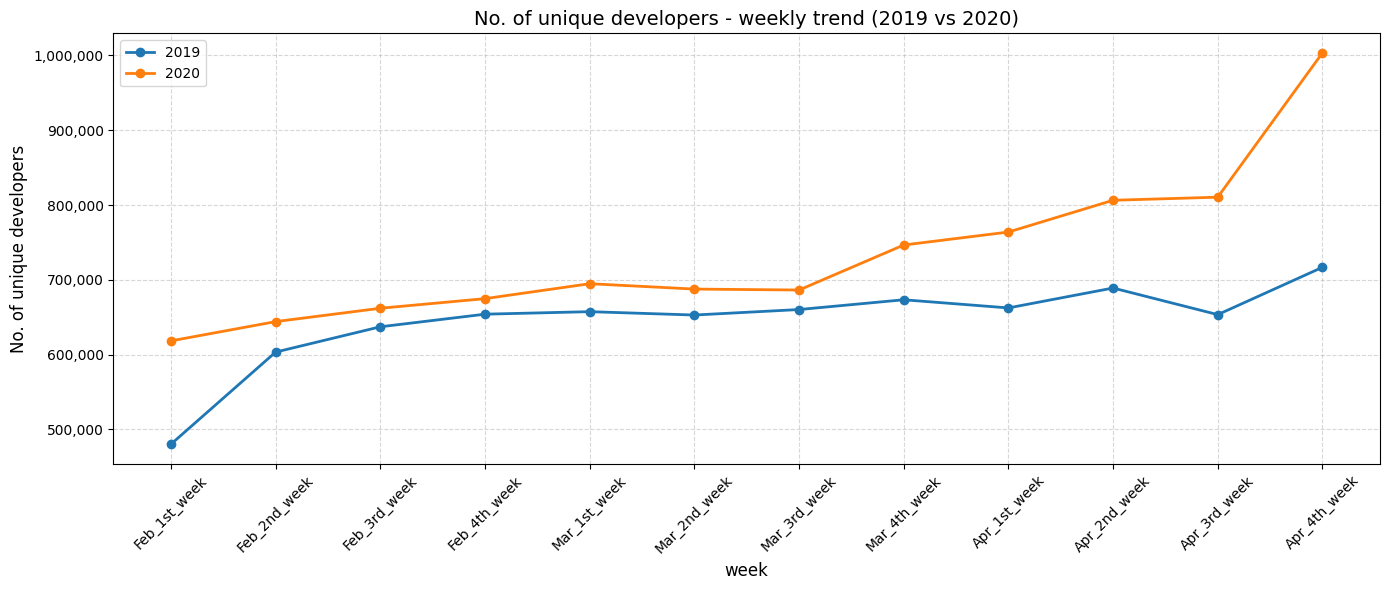

In [ ]:
# plotting for no of developers
metrics_plot(com_network_metrics, 'num_nodes','No. of unique developers')

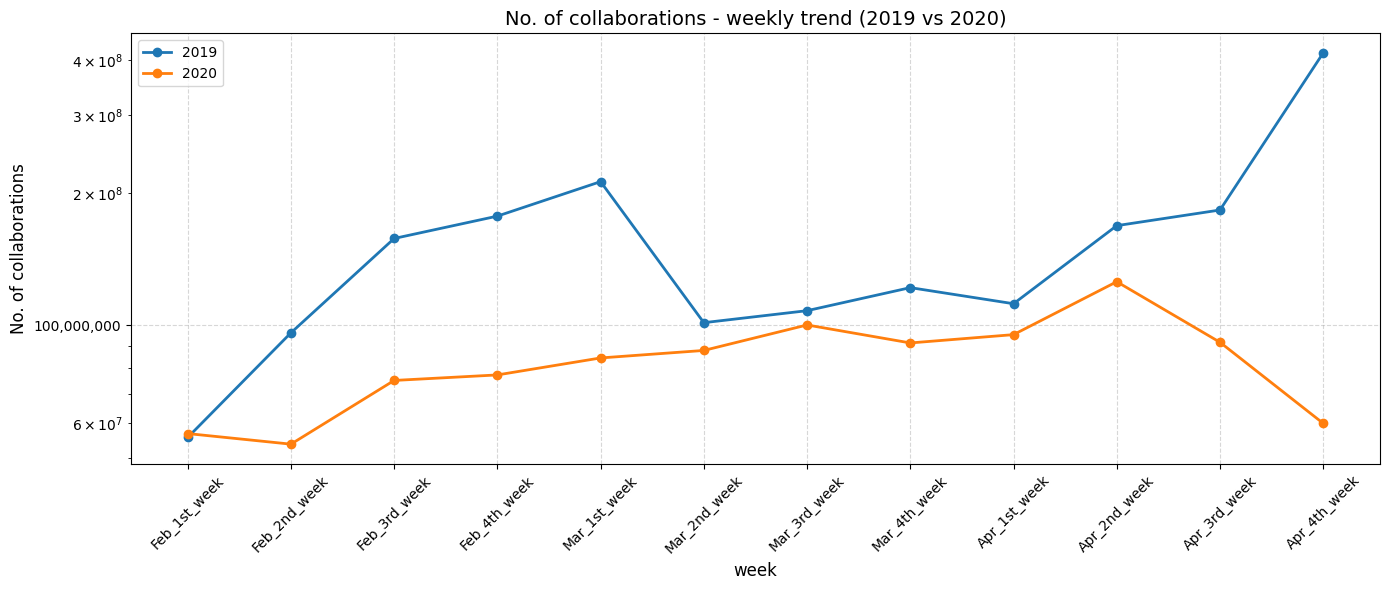

In [ ]:
# plotting for collaborations over time
metrics_plot(com_network_metrics, 'num_edges', 'No. of collaborations', use_log = True)

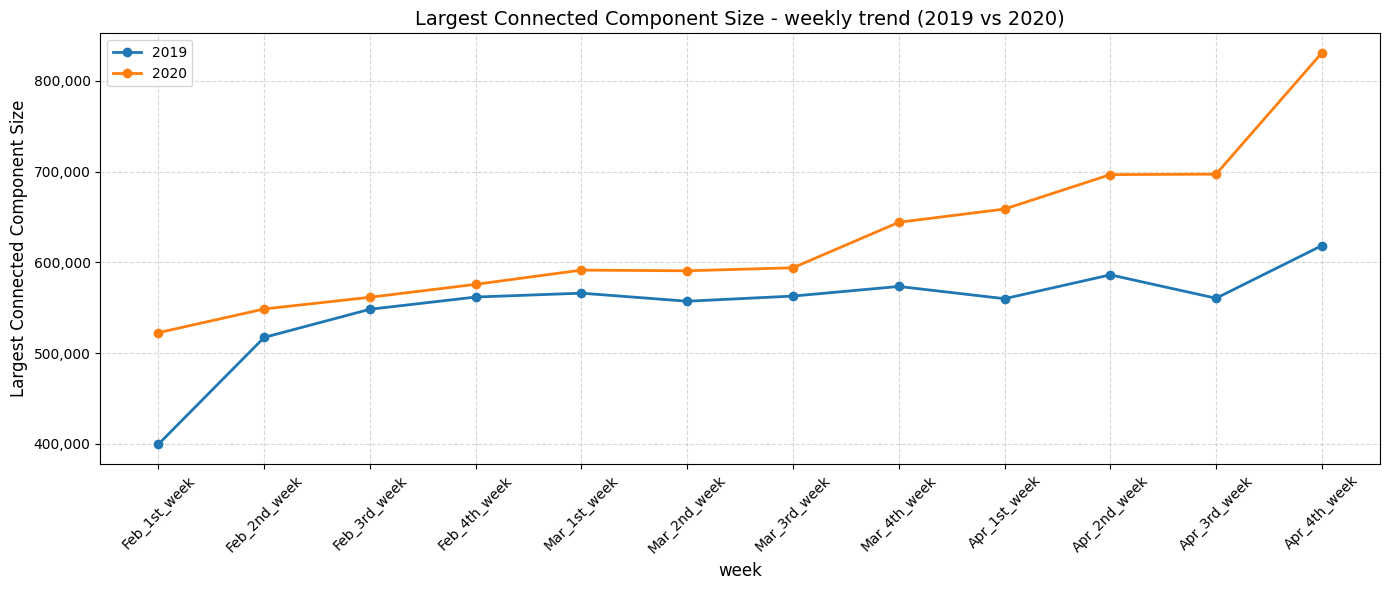

In [ ]:
# plotting largest no. of developers in the biggest connected clusters
metrics_plot(com_network_metrics, 'largest_component_size', 'Largest Connected Component Size')

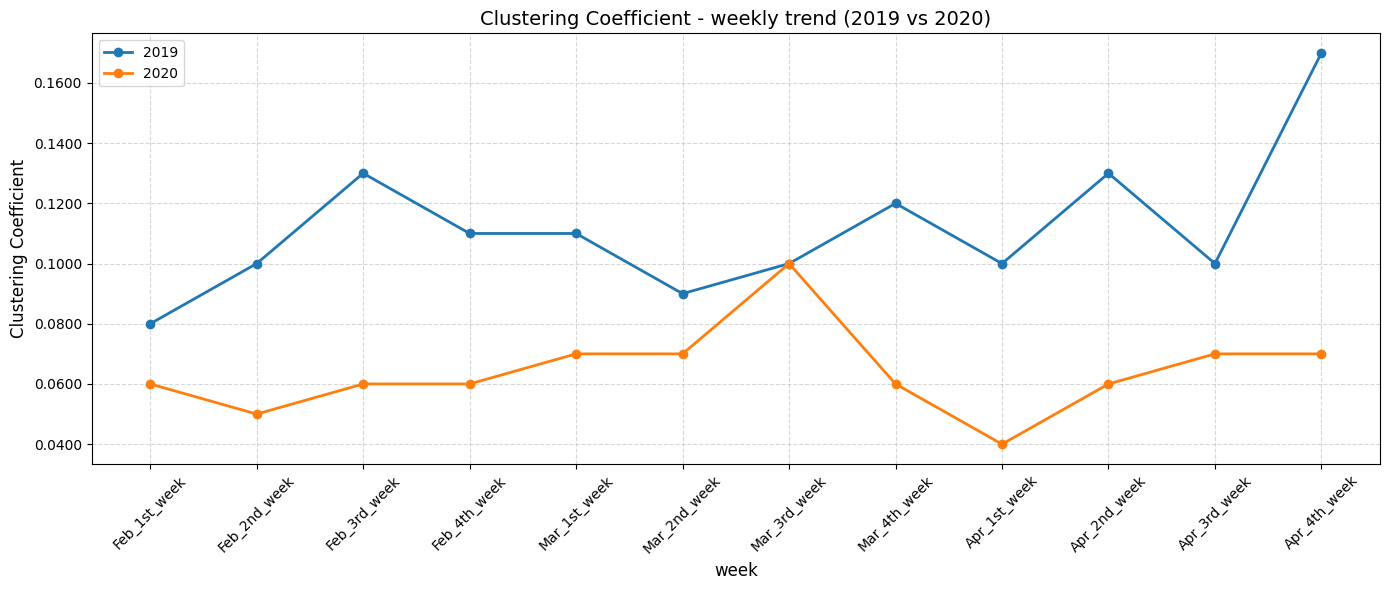

In [ ]:
# plotting clustering coefficient trend
metrics_plot(com_network_metrics, 'clustering_coefficient', 'Clustering Coefficient')

The network analysis trends for common developers which are active in both 2019 and 2020, closely mirrors the patterns observed in the network metrics from full dataset. Despite focusing on a more consistent subset of contributors, key metrics like density, average degree and clustering coefficient follow similar weekly trajectories. This consistency reinforces the validity of earlier insights, suggesting that the broader shifts in developer collaboration behavior during the pre and post COVID periods are also reflected within this core group of persitent contributors.